# 微调LLM详细教程

![](https://huggingface.co/front/assets/huggingface_logo-noborder.svg)

1. 数据

- 单轮对话场景
- 多轮对话场景
- labels mask

2. 模型

- 量化
- how to find lora modules / lora config (p-tuning等方法之后有机会出)
- Loss and input_ids shift

3. 训练

- Trainer, TrainingArguments, HfArgumentParser

# 数据

选取`BelleGroup/train_0.5M_CN`数据集来对语言模型训练数据集处理进行介绍.

In [ ]:
from datasets import Dataset, load_dataset
# https://huggingface.co/datasets/BelleGroup/train_0.5M_CN/blob/main/Belle_open_source_0.5M.json
ds = Dataset.from_json("./data/Belle_open_source_0.5M.json")
ds[0]

In [ ]:
  pip uninstall jupyter

可以观察到数据是单轮对话数据,输入`instruction`和`input`,希望模型能够按照`output`进行回复. Decoder-Only语言模型通过预测下一个token进行训练,因此我们需要按照需要的场景对数据进行组织.

![](http://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif)

## 单轮对话场景

**方案(1)**:直接将`instruction`, `input`, `output` 合并,作为文本输入,模型每次预测下一个单词. 这种方法简单,但是存在2个问题.
1. 模型无法学习到何时结束对话(输出`eos_token`即`end of sentence toeken`)
2. 模型无法对问题和回答做有效的区分

In [21]:
print(ds[0]['instruction'] + ds[0]['input'] + ds[0]['output'])

给定一个英文句子，翻译成中文。
I love to learn new things every day.
我每天喜欢学习新事物。


**方案(2)**:在方案(1)基础上,最后一个位置添加`eos_token`

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./pretrained/baichuan-7b/", trust_remote_code=True)

print(ds[0]['instruction'] + ds[0]['input'] + ds[0]['output'] + tokenizer.eos_token)

给定一个英文句子，翻译成中文。
I love to learn new things every day.
我每天喜欢学习新事物。</s>


**方案(3)**:在方案2基础上更进一步,添加有效的区分信息.

In [19]:
print("Human: "+ ds[0]['instruction'] + ds[0]['input'] + "\n\nAssistant:" + ds[0]['output'] + tokenizer.eos_token)

Human: 给定一个英文句子，翻译成中文。
I love to learn new things every day.


Assistant:我每天喜欢学习新事物。</s>


按照**方案(3)**的思路,我们可以构建数据处理函数:

In [22]:
def belle_open_source_500k(data_file, tokenizer, max_len):
    # https://huggingface.co/datasets/BelleGroup/train_0.5M_CN/blob/main/Belle_open_source_0.5M.json
    def tokenize(prompt, add_eos_token=True):
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=max_len,
            padding=False,
            return_tensors=None,
        )
        if (
                result["input_ids"][-1] != tokenizer.eos_token_id
                and len(result["input_ids"]) < max_len
                and add_eos_token
        ):
            result["input_ids"].append(tokenizer.eos_token_id)
            result["attention_mask"].append(1)

        if add_eos_token and len(result["input_ids"]) >= max_len:
            result["input_ids"][max_len - 1] = tokenizer.eos_token_id
            result["attention_mask"][max_len - 1] = 1

        result["labels"] = result["input_ids"].copy()
        return result


    def generate_and_tokenize_prompt(data_point):
        instruction = data_point['instruction']
        input_text = data_point["input"]
        input_text = "Human: " + instruction + input_text + "\n\nAssistant: "
        input_text = tokenizer.bos_token + input_text if tokenizer.bos_token != None else input_text
        target_text = data_point["output"] + tokenizer.eos_token
        full_prompt = input_text + target_text
        tokenized_full_prompt = tokenize(full_prompt)
        return tokenized_full_prompt

    data = load_dataset("json", data_files=data_file)["train"]
    data = data.map(generate_and_tokenize_prompt, num_proc=8)
    return data

In [24]:
ds = belle_open_source_500k("./data/Belle_open_source_0.5M.json", tokenizer, max_len=512)

Found cached dataset json (/home/kky/.cache/huggingface/datasets/json/default-46b81080a00b6e53/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.26it/s]


In [29]:
ds[0]['input_ids'][:10]

[1, 5132, 31143, 31106, 31423, 31261, 1197, 15215, 22667, 72]

In [27]:
tokenizer.decode(ds[0]['input_ids'])

'<s> Human: 给定一个英文句子，翻译成中文。\nI love to learn new things every day.\n\n\nAssistant: 我每天喜欢学习新事物。</s>'

## 多轮对话场景

多轮对话与单轮对话的区别在于, 有多个轮次的交互信息,一些模型比如`ChatGLM`将轮次信息写入到上下文,让模型能够获得对多轮对话更有层次的信息利用.

```python

def build_inputs(self, tokenizer, query: str, history: List[Tuple[str, str]] = None):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response)
    prompt += "[Round {}]\n\n问：{}\n\n答：".format(len(history) + 1, query)
    inputs = tokenizer([prompt], return_tensors="pt")
    inputs = inputs.to(self.device)
    return inputs
    
```

## Label Mask

相信一些同学看到这里已经有一些想法,我们其实希望模型能够有效的回答问题,但是如果按照我们上面的数据处理方式,模型其实还在预测:
1. 额外添加的辅助信息,比如轮次等
2. 人类提问

因此我们可以定义一个`Label Mask`让模型计算loss的时候,不考虑这些token,专注与训练模型回答.

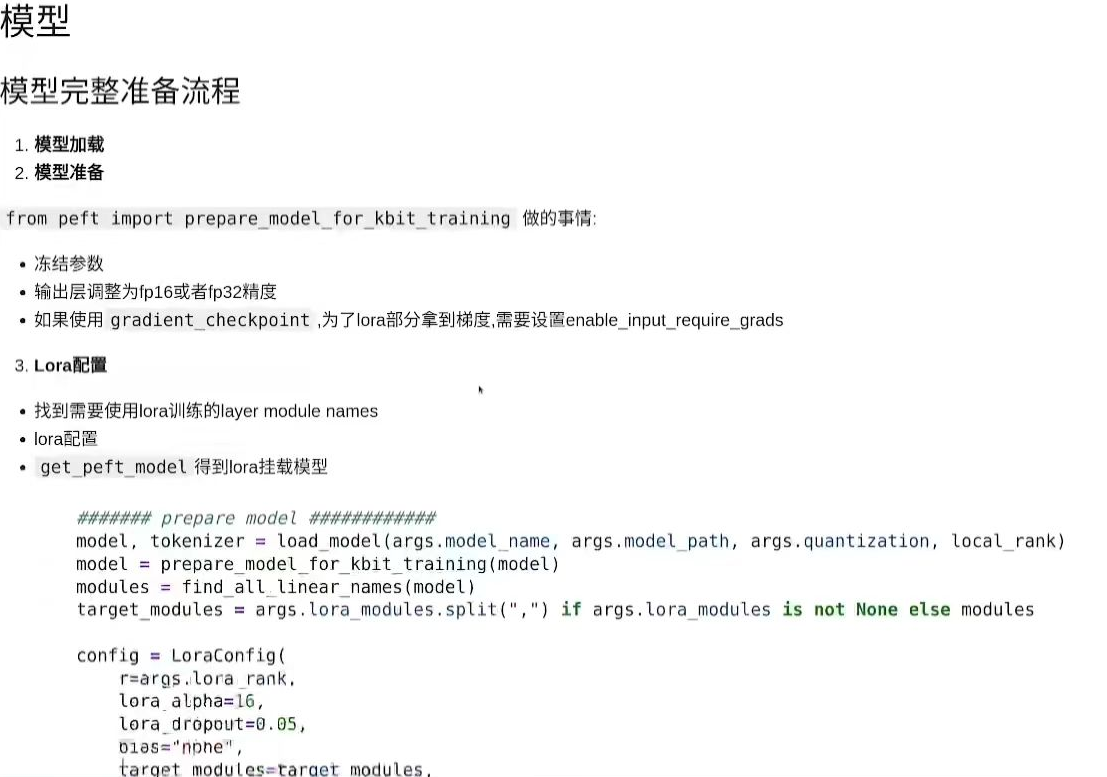

# 模型

## 量化加载
- baichuan-7B显存开销 `float16` (13GB), `8bit` (7.1GB), `4bit` (4.1GB)
- 模型定义变化 `torch.nn.Linear` => `bitsandbytes.nn.Linear8bitLt` => `bitsandbytes.nn.Linear4bit`

In [1]:
import os
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

/home/4T/tangshunye/.conda/envs/ft-bc/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = AutoModelForCausalLM.from_pretrained(
            "./pretrained/baichuan-7b/",
            device_map={"": 6},
            torch_dtype=torch.float16,
            trust_remote_code=True,
        )
print(f'memory usage of model: {model.get_memory_footprint() / (1024 * 1024 * 1024):.2} GB')
model

memory usage of model: 1.3e+01 GB


BaiChuanForCausalLM(
  (model): Model(
    (embed_tokens): Embedding(64000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x DecoderLayer(
        (self_attn): Attention(
          (W_pack): Linear(in_features=4096, out_features=12288, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
        )
        (mlp): MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=64000, bias=False)
)

In [2]:
model = AutoModelForCausalLM.from_pretrained(
            "./pretrained/baichuan-7b/",
            device_map={"": 0},
            load_in_8bit=True,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            quantization_config=BitsAndBytesConfig(
                load_in_8bit=True,
                llm_int8_threshold=6.0
            )
        )
print(f'memory usage of model: {model.get_memory_footprint() / (1024 * 1024 * 1024):.2} GB')
model


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/kky/miniconda3/envs/torch2/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/kky/miniconda3/envs/torch2/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/kky/miniconda3/envs/torch2/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...
memory usage of model: 7.1 GB


BaiChuanForCausalLM(
  (model): Model(
    (embed_tokens): Embedding(64000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x DecoderLayer(
        (self_attn): Attention(
          (W_pack): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
        )
        (mlp): MLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=64000, bias=False)
)

In [5]:
model = AutoModelForCausalLM.from_pretrained(
            "./pretrained/baichuan-7b/",
            device_map={"": 6},
            trust_remote_code=True,
            quantization_config=BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
            ),
        )

print(f'memory usage of model: {model.get_memory_footprint() / (1024 * 1024 * 1024):.2} GB')
model

memory usage of model: 4.1 GB


BaiChuanForCausalLM(
  (model): Model(
    (embed_tokens): Embedding(64000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x DecoderLayer(
        (self_attn): Attention(
          (W_pack): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
        )
        (mlp): MLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=64000, bias=False)
)

## 找到需要Lora finetune的Module Names

1. 如果已经进行了量化加载,可以通过模型类进行寻找

In [6]:
import bitsandbytes as bnb

lora_module_names = set()
for name, module in model.named_modules():
    if isinstance(module, bnb.nn.Linear4bit):
        names = name.split('.')
        lora_module_names.add(names[0] if len(names) == 1 else names[-1])


if 'lm_head' in lora_module_names: # needed for 16-bit or 32-bit
    lora_module_names.remove('lm_head')

list(lora_module_names)

['up_proj', 'gate_proj', 'W_pack', 'down_proj', 'o_proj']

2. 根据模型Module名称手动指定
```python
lora_module_names = ["W_pack"]
```

## Label shift and Loss

语言模型一般采用`CrossEntropyLoss`,需要注意的是一般会设置`ignore_index=tokenizer.pad_token_id`,这个在`Transformers`库中的模型已经内置实现了. 另外在模型`forward`过程中会自动的对`input_ids`进行`shift`1位的操作得到`labels`. 下面代码为`transformers`库源码,其中输入的`input_ids`和`labels`是完全一致的,但是模型需要预测的是下一个单词,因此将`labels`进行`shift`操作即可得到我们需要的真正`labels`.


```python
# https://huggingface.co/baichuan-inc/baichuan-7B/blob/5bcc98cbecaee775d90c9a168cc526bbabcf0983/modeling_baichuan.py#L612
if labels is not None:
        # Shift so that tokens < n predict n
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        # Flatten the tokens
        loss_fct = CrossEntropyLoss()
        shift_logits = shift_logits.view(-1, self.config.vocab_size)
        shift_labels = shift_labels.view(-1)
        # Enable model parallelism
        shift_labels = shift_labels.to(shift_logits.device)
        loss = loss_fct(shift_logits, shift_labels)
vocab_size 在模型输出中的含义
在模型的输出层，vocab_size 决定了预测结果的维度。对于每个输入 token，模型输出一个大小为 vocab_size 的向量，这个向量表示词汇表中每个词的概率。以下是一个示例：

假设 vocab_size = 5，表示词汇表包含 5 个词：["I", "love", "NLP", "deep", "learning"]。
如果模型的输出是一个向量 [0.1, 0.3, 0.4, 0.1, 0.1]，则表示模型认为 “NLP” 是最有可能的下一个词（因为 0.4 是最高的概率）。
```

# 训练

`transformers`内置的**Trainer**已经实现了几乎完整的语言模型训练功能,在实践时一般只需要对`compute_loss`方法进行重写即可, 例如:

```python
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
```

**TrainingArguments**则定义了绝大部分训练需要的参数,和**Trainer**配套使用.主要参数:

```latex
num_train_epochs   迭代次数
learning_rate      学习率
per_device_train_batch_size  每个GPU batch_size, num_gpu * per_device_train_batch_size = 真正的batch_size
gradient_accumulation_steps  累计梯度
logging_steps                日志频率
report_to                    日志存储,一般设置为wandb或者tensorboard
optim                        优化器,一般设置adamw_torch
ddp_find_unused_parameters   在使用DDP分布式训练时,一定要设这这个参数为false
```


**HfArgumentParser**可以很方便的代替`argpare`库,常常和**TrainingArguments**一起使用. 这里举例,首先定义一些其他需要传入的参数:

```python
from dataclasses import field, fields, dataclass

@dataclass
class FinetuneArguments:
    model_name: str = field()
    model_path: str = field()
    data_name: str = field()
    data_path: str = field()
    train_size: int = field(default=-1)
    test_size: int = field(default=200)
    max_len: int = field(default=1024)
    lora_rank: int = field(default=8)
    lora_modules: str = field(default=None)
    quantization: str = field(default="4bit")

# 这种定义中 arg_name: bool=filed(default=False)等价于 parser.add_argument("--arg_name", action="store_true")
```

然后所有参数一起解析:

```python

args, training_args = HfArgumentParser(
        (FinetuneArguments, TrainingArguments)
    ).parse_args_into_dataclasses()

```

这样所有参数都可以通过 `python script.py --model_name ....`方式传入, 其中属于`FinetuneArguments`的部分会被记录到`args`下, `TrainingArguments`记录到`training_args`下.下

# Finetune模型测试

In [1]:
import os
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import datasets
from peft import PeftModel, prepare_model_for_kbit_training
import os
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel, LoraConfig, get_peft_model
from model import load_model
from peft import PeftModel
from transformers import  GenerationConfig

/home/kky/miniconda3/envs/torch2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/kky/miniconda3/envs/torch2/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/kky/miniconda3/envs/torch2/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/kky/miniconda3/envs/torch2/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


In [2]:
model, tokenizer = load_model("baichuan", "./pretrained/baichuan-7b/", quantization="4bit")
lora_model = PeftModel.from_pretrained(model, "./output/baichuan_lorasft/")

generation_config = GenerationConfig(
        temperature=0.5,
        top_p = 0.85,
        do_sample = True, 
        repetition_penalty=2.0, 
        max_new_tokens=1024,  # max_length=max_new_tokens+input_sequence

)
device = model.device

load model with 4bit quantization
pass unk_token_id 0 to pad_token_id
memory usage of model: 4.1 GB


In [3]:
prompt = "帮我取一个很独特的网名"
input ="Human: " + prompt + "\n\nAssistant: "
inputs = tokenizer(input,return_tensors="pt").to(device)
generate_ids = lora_model.generate(**inputs, generation_config=generation_config)
output = tokenizer.decode(generate_ids[0][len(inputs.input_ids[0]):])
print(output)

 我的名字是“小黑”，你可以考虑使用这个作为你的网络昵称。</s>


In [4]:
prompt = "这段话翻译成英文: '代表未知、无限可能'"
input ="Human: " + prompt + "\n\nAssistant: "
inputs = tokenizer(input,return_tensors="pt").to(device)
generate_ids = lora_model.generate(**inputs, generation_config=generation_config)
output = tokenizer.decode(generate_ids[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
print(output)

「Unknown and infinite possibilities」


In [5]:
prompt = "帮我取一个很月亮有关且很独特的网名"
input ="Human: " + prompt + "\n\nAssistant: "
inputs = tokenizer(input,return_tensors="pt").to(device)
generate_ids = lora_model.generate(**inputs, generation_config=generation_config)
output = tokenizer.decode(generate_ids[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
print(output)

「月夜之舞」


**祝大家玩的愉快! 更详细的LLM视频更新在我的视频媒体上,欢迎关注.**
- b站频道: https://space.bilibili.com/1751715710/channel/collectiondetail?sid=1485775
- youtube: https://www.youtube.com/channel/UCxu8MUtWtqfdDB2eTABSePg